E14. Diagnosis of pneumonia
===

흉부 X-ray사진을 보고 폐렴을 진단할 수 있는 진단기를 만들어보자. 또한, regularization과 augmentation 기법을 도입하여 베이스라인 코드와 비교하여 ablation study를 해보자.


**Data**

[데이터](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) <br/>
[데이터에 관한 정보](https://biology-statistics-programming.tistory.com/60?category=955669)

## Step 0. 사전지식

#### 의료영상 이미지의 특징
- 개인정보 등으로 인해 데이터를 구하는 것이 쉽지 않다.
- 라벨링 작업 자체가 전문적 지식을 요구하여 데이터셋 구축 비용이 비싸다.
- 음성/양성 데이터간 imbalance 가 심하다.
- 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석해야할 수도 있다.

#### 흉부 X-ray의 특징
- 갈비뼈 :: 하얀색
- 폐 :: 검은색
- 어깨 쪽의 지방 및 근육 :: 연한 회색

#### 폐렴 구별법
X-RAY 사진상, 다양한 양상의 음영 증가가 관찰된다.

![image](https://user-images.githubusercontent.com/70703320/117413265-b7279080-af50-11eb-920d-ecab72fc893d.png)

|정상적인 흉부 X-ray|세균성 폐렴|바이러스성 폐렴|
|:---:|:---:|:---:|
|깨끗한 폐 사진|오른쪽 상부옆|양쪽 폐에서 interstitial 패턴|


## Step 1. 실험환경 Set-up

#### 라이브러리

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

### 필요한 변수 생성 

||base line|좌우 반전|대비 조절|Dropout 비율변경|
|:---:|:---:|:---:|:---:|:---:|
|**bacth size**|32|32|32|32|
|**epoch**|30|30|30|30|

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE_1 = 32
BATCH_SIZE_2 = 32
BATCH_SIZE_3 = 32
BATCH_SIZE_4 = 32
BATCH_SIZE_5 = 32

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS_1 = 30
EPOCHS_2 = 30
EPOCHS_3 = 30
EPOCHS_4 = 30
EPOCHS_5 = 30

print(ROOT_PATH)

/home/aiffel-dj63/aiffel


## Step 2. 데이터 준비하기

#### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개

갯수 비는 89%, 10.7%, 0.3%, val 갯수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보기

#### train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### train 데이터 안에 정상 이미지 수와 폐렴 이미지 수

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


#### tf.data 인스턴스를 만들기

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### Train 데이터 셋, validation 데이터 셋 갯수 확인

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


#### 라벨 이름들을 확인

In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


#### 라벨 데이터를 만들어 주는 함수를 만들어 보기

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자.

#### decode_img 함수와 process_path 함수를 만들기

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train 데이터 셋과 validation 데이터 셋을 만들기

#### num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### augmentation

||base line|좌우반전|대비 조절|drop out 제거|regularization|
|:---:|:---:|:---:|:---:|:---:|:---:|
|**augmentation**|X|O|O|O|X|

baseline

In [12]:
def prepare_for_training_1(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE_1)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_1 = prepare_for_training_1(train_ds)
val_ds_1 = prepare_for_training_1(val_ds)

좌우반전

In [13]:
def augment_LR(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_LR(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment_LR,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE_2)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_2 = prepare_for_training_LR(train_ds)
val_ds_2 = prepare_for_training_LR(val_ds)


대비 조절

In [14]:
def augment_C(image,label):
    image = tf.image.adjust_contrast(image, 0.5)  # 이미지의 대비를 조절
    return image,label

def prepare_for_training_C(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment_C,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE_3)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_3 = prepare_for_training_C(train_ds)
val_ds_3 = prepare_for_training_C(val_ds)

drop out 제거

In [15]:
def prepare_for_training_4(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE_4)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_4 = prepare_for_training_4(train_ds)
val_ds_4 = prepare_for_training_4(val_ds)

regularization

In [16]:
def prepare_for_training_5(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE_5)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_5 = prepare_for_training_5(train_ds)
val_ds_5 = prepare_for_training_5(val_ds)

#### Image shape를 변경해주는 것 체크하기

In [17]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [18]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_1 = test_ds.batch(BATCH_SIZE_1)
test_ds_2 = test_ds.batch(BATCH_SIZE_2)
test_ds_3 = test_ds.batch(BATCH_SIZE_3)
test_ds_4 = test_ds.batch(BATCH_SIZE_4)
test_ds_5 = test_ds.batch(BATCH_SIZE_5)

print(TEST_IMAGE_COUNT)

624


prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환

## Step 3. 데이터 시각화

base line

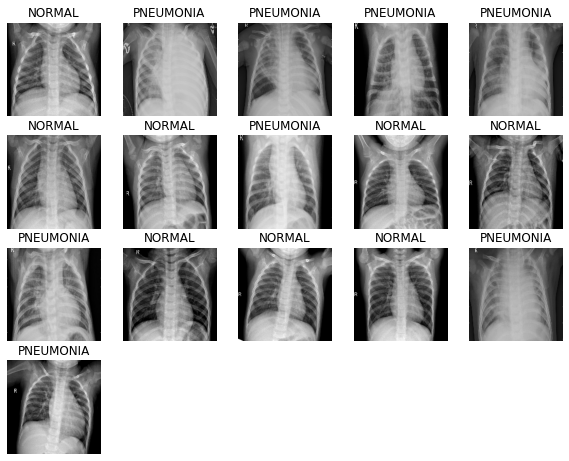

In [19]:
image_batch_1, label_batch_1 = next(iter(train_ds_1))

def show_batch_1(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch_1[n])
        if label_batch_1[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch_1(image_batch_1.numpy(), label_batch_1.numpy())

좌우 반전

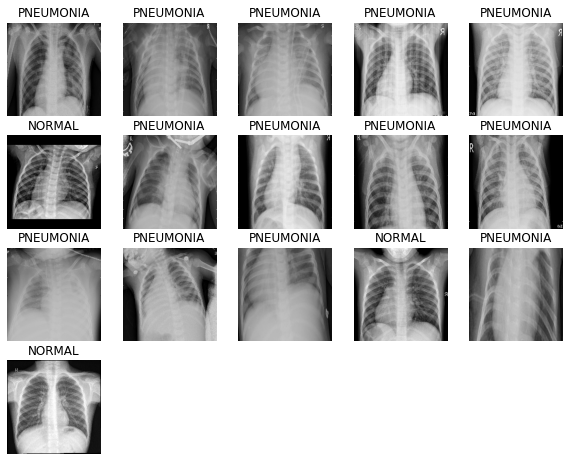

In [20]:
image_batch_2, label_batch_2 = next(iter(train_ds_2))

def show_batch_2(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch_2[n])
        if label_batch_2[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch_2(image_batch_2.numpy(), label_batch_2.numpy())

대비 조절

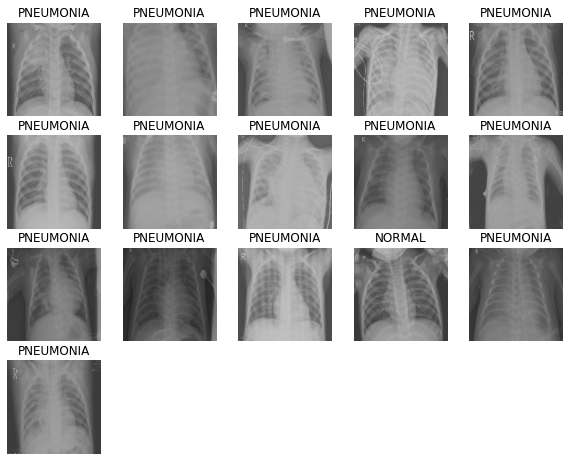

In [21]:
image_batch_3, label_batch_3 = next(iter(train_ds_3))

def show_batch_3(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch_3[n])
        if label_batch_3[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch_3(image_batch_3.numpy(), label_batch_3.numpy())

drop out 제거

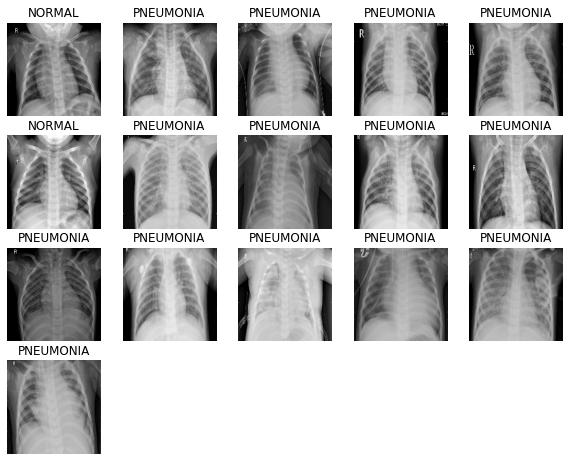

In [22]:
image_batch_4, label_batch_4 = next(iter(train_ds_4))

def show_batch_4(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch_4[n])
        if label_batch_4[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch_4(image_batch_4.numpy(), label_batch_4.numpy())

regularization

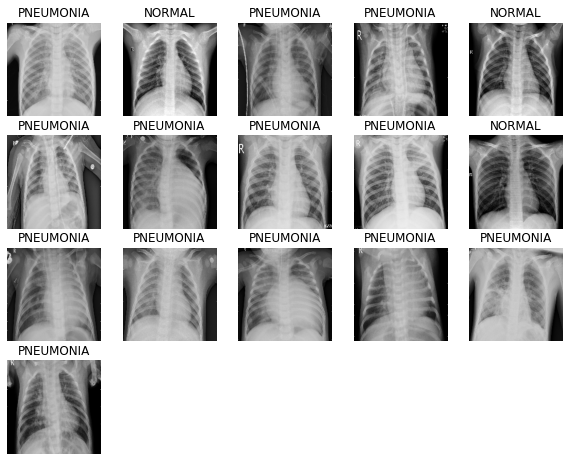

In [23]:
image_batch_5, label_batch_5 = next(iter(train_ds_5))

def show_batch_5(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch_5[n])
        if label_batch_5[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch_5(image_batch_5.numpy(), label_batch_5.numpy())

## Step 4. CNN 모델링

#### Conv Block

In [24]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

#### Dense Block

In [25]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [26]:
def dense_block_d0(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

### model building

||base line|좌우 반전|대비 조절|drop out 제거|regularization|
|:---:|:---:|:---:|:---:|:---:|:---:|
|**conv_block max**|256|256|256|256|256|
|**dense_block max**|512|512|512|512|512|
|**regularization**|X|X|X|X|O|

base line

In [27]:
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

좌우 반전

In [28]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

대비 조절

In [29]:
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

drop out 제거

In [30]:
def build_model_4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),        
        conv_block(128),        
        conv_block(256),  # drop out 제거
        
        tf.keras.layers.Flatten(),
        dense_block_d0(512),
        dense_block_d0(128),
        dense_block_d0(64),  # drop out 제거된 dense_block 사용
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

regularization

In [31]:
def build_model_5():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해주었다. 이를 생략한다면? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과?

#### 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [32]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


## Step 6. 모델 훈련

### GPU사용하여 model complie

optimizer나 learning rate 등의 변화를 고려

#### base line

In [33]:
with tf.device('/GPU:0'):
    model_1 = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### 좌우 반전

In [34]:
with tf.device('/GPU:0'):
    model_2 = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### 대비 조절

In [35]:
with tf.device('/GPU:0'):
    model_3 = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### drop out 제거

In [36]:
with tf.device('/GPU:0'):
    model_4 = build_model_4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### regularization

In [37]:
with tf.device('/GPU:0'):
    model_5 = build_model_5()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### model fit

base line

In [38]:
with tf.device('/GPU:0'):
    history_1 = model_1.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_1,
        epochs=EPOCHS_1,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_1,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 53s 196ms/step - loss: 0.5191 - accuracy: 0.7172 - precision: 0.9226 - recall: 0.6772 - val_loss: 0.5900 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 25s 192ms/step - loss: 0.2024 - accuracy: 0.9160 - precision: 0.9796 - recall: 0.9071 - val_loss: 0.8047 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 25s 192ms/step - loss: 0.1895 - accuracy: 0.9306 - precision: 0.9772 - recall: 0.9293 - val_loss: 1.1418 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 26s 197ms/step - loss: 0.1560 - accuracy: 0.9426 - precision: 0.9821 - recall: 0.9403 - val_loss: 1.8106 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 26s 204ms/step - loss: 0.1459 - accura

좌우 반전

In [39]:
with tf.device('/GPU:0'):
    history_2 = model_2.fit(
        train_ds_2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_2,
        epochs=EPOCHS_2,
        validation_data=val_ds_2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_2,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 32s 205ms/step - loss: 0.5536 - accuracy: 0.6874 - precision: 0.9101 - recall: 0.6422 - val_loss: 0.5823 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 25s 196ms/step - loss: 0.2423 - accuracy: 0.8957 - precision: 0.9753 - recall: 0.8833 - val_loss: 0.7336 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 25s 195ms/step - loss: 0.1950 - accuracy: 0.9248 - precision: 0.9762 - recall: 0.9215 - val_loss: 0.8582 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 26s 197ms/step - loss: 0.1637 - accuracy: 0.9407 - precision: 0.9841 - recall: 0.9364 - val_loss: 1.1796 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 26s 202ms/step - loss: 0.1674 - accura

대비 조절

In [40]:
with tf.device('/GPU:0'):
    history_3 = model_3.fit(
        train_ds_3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_3,
        epochs=EPOCHS_3,
        validation_data=val_ds_3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_3,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 32s 200ms/step - loss: 0.6813 - accuracy: 0.6237 - precision: 0.8614 - recall: 0.5886 - val_loss: 0.5762 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 26s 198ms/step - loss: 0.2634 - accuracy: 0.8879 - precision: 0.9765 - recall: 0.8719 - val_loss: 0.7332 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 26s 199ms/step - loss: 0.1978 - accuracy: 0.9180 - precision: 0.9815 - recall: 0.9071 - val_loss: 0.9310 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 26s 200ms/step - loss: 0.1386 - accuracy: 0.9478 - precision: 0.9871 - recall: 0.9425 - val_loss: 1.1744 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 27s 205ms/step - loss: 0.1360 - accura

drop out 제거

In [41]:
with tf.device('/GPU:0'):
    history_4 = model_4.fit(
        train_ds_4,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_4,
        epochs=EPOCHS_4,
        validation_data=val_ds_4,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_4,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 31s 198ms/step - loss: 0.2461 - accuracy: 0.8952 - precision: 0.9732 - recall: 0.8834 - val_loss: 0.5813 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 25s 195ms/step - loss: 0.1401 - accuracy: 0.9433 - precision: 0.9835 - recall: 0.9396 - val_loss: 0.7532 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 25s 195ms/step - loss: 0.0999 - accuracy: 0.9645 - precision: 0.9850 - recall: 0.9669 - val_loss: 1.0666 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 25s 196ms/step - loss: 0.0928 - accuracy: 0.9623 - precision: 0.9874 - recall: 0.9621 - val_loss: 1.5810 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 26s 201ms/step - loss: 0.0703 - accura

regularization

In [42]:
with tf.device('/GPU:0'):
    history_5 = model_5.fit(
        train_ds_5,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_5,
        epochs=EPOCHS_5,
        validation_data=val_ds_5,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_5 ,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 34s 212ms/step - loss: 0.4778 - accuracy: 0.7548 - precision: 0.9382 - recall: 0.7180 - val_loss: 0.6424 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 26s 201ms/step - loss: 0.2180 - accuracy: 0.9200 - precision: 0.9786 - recall: 0.9130 - val_loss: 0.7363 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 26s 201ms/step - loss: 0.1706 - accuracy: 0.9476 - precision: 0.9836 - recall: 0.9458 - val_loss: 0.8133 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 26s 203ms/step - loss: 0.1512 - accuracy: 0.9531 - precision: 0.9856 - recall: 0.9509 - val_loss: 1.1765 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 28s 214ms/step - loss: 0.1228 - accura

## Step 7. 결과 확인과 시각화

의료영상 모델의 특성상 recall도 중요, 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석

### 결과 확인

base line

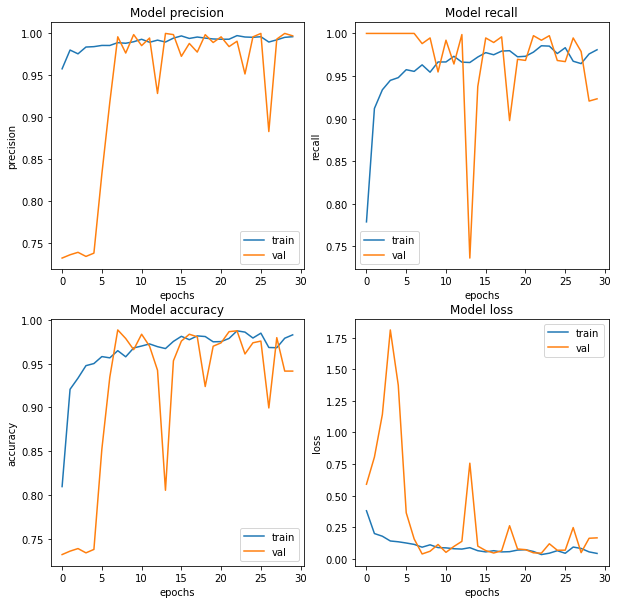

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_1.history[met])
    ax[i].plot(history_1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

좌우 반전

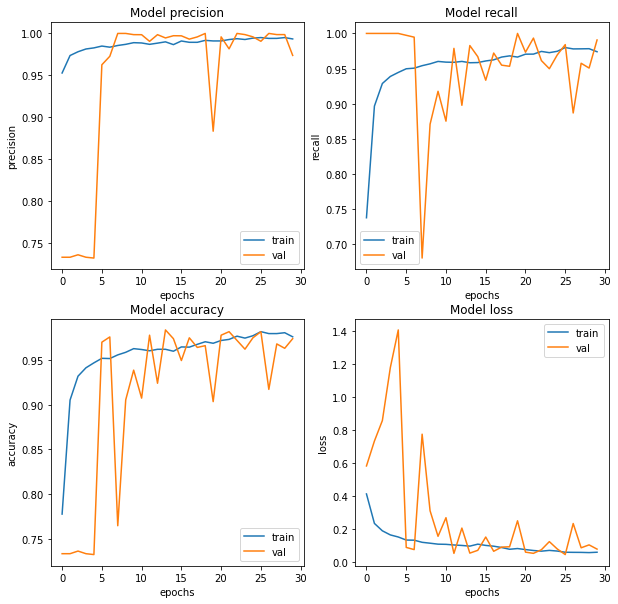

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_2.history[met])
    ax[i].plot(history_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

대비 조절

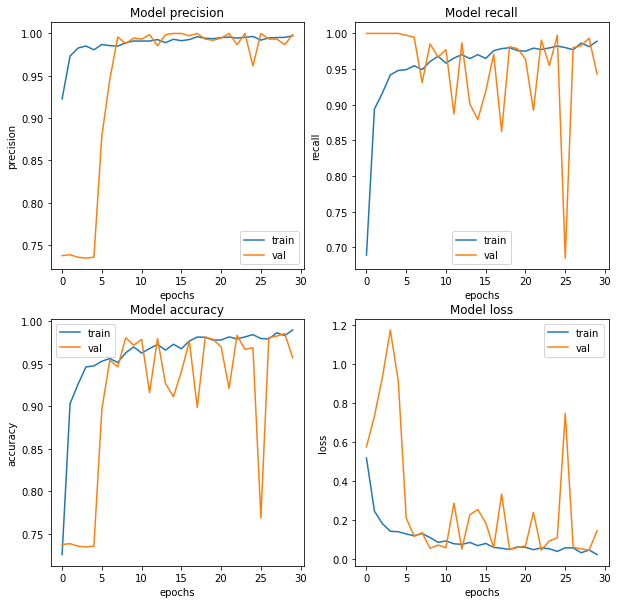

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_3.history[met])
    ax[i].plot(history_3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

drop out 제거

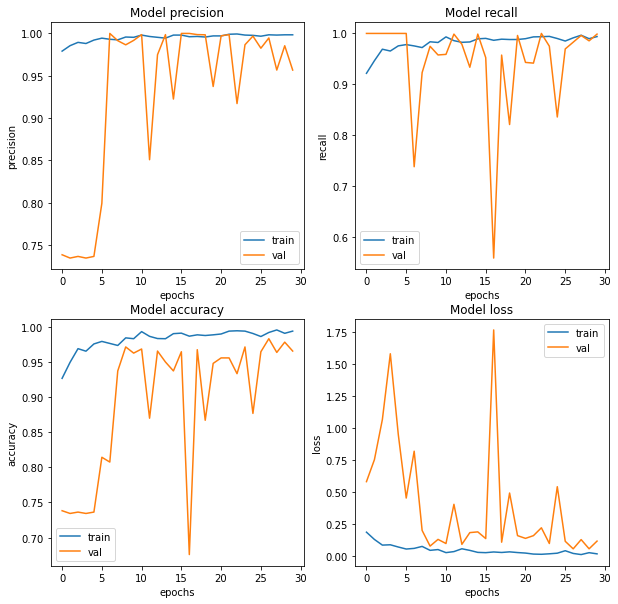

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_4.history[met])
    ax[i].plot(history_4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

regularization

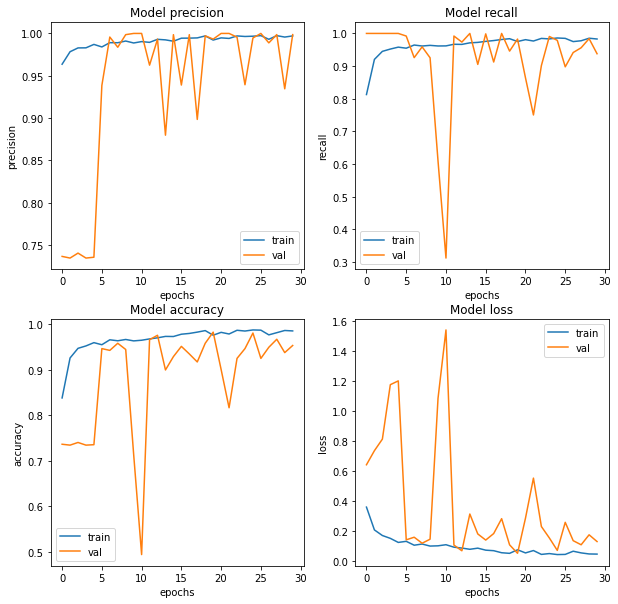

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_5.history[met])
    ax[i].plot(history_5.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

base line

In [48]:
loss_1, acc_1, prec_1, rec_1 = model_1.evaluate(test_ds_1)

20/20 [==============================] - 16s 816ms/step - loss: 0.6200 - accuracy: 0.8462 - precision: 0.8114 - recall: 0.9821


좌우 반전

In [49]:
loss_2, acc_2, prec_2, rec_2 = model_2.evaluate(test_ds_2)

20/20 [==============================] - 3s 113ms/step - loss: 1.3694 - accuracy: 0.7324 - precision: 0.7031 - recall: 0.9897


대비 조절

In [50]:
loss_3, acc_3, prec_3, rec_3 = model_3.evaluate(test_ds_3)

20/20 [==============================] - 3s 113ms/step - loss: 0.8286 - accuracy: 0.8862 - precision: 0.8789 - recall: 0.9487


drop out 제거

In [51]:
loss_4, acc_4, prec_4, rec_4 = model_4.evaluate(test_ds_4)

20/20 [==============================] - 3s 111ms/step - loss: 2.0224 - accuracy: 0.6939 - precision: 0.6713 - recall: 1.0000


regularization

In [52]:
loss_5, acc_5, prec_5, rec_5 = model_5.evaluate(test_ds_5)

20/20 [==============================] - 3s 111ms/step - loss: 0.6730 - accuracy: 0.8253 - precision: 0.8035 - recall: 0.9538


||base model|좌우 반전|대비 조절|drop out 제거|regularization|
|:---:|:---:|:---:|:---:|:---:|:---:|
|Accuracy|0.8462|0.7324|0.8862|0.6939|0.8253|
|Recall|0.9821|0.9897|0.9487|1.0000|0.9538|

## 회고

ablation study (machine learning system의 building blocks을 제거해서 전체 성능에 미치는 효과에 대한 insight를 얻기 위한 과학적 실험)를 하기 위한 노력
- augmentation 기법을 사용: prepare_for_training 함수 안에 augment 함수를 만들어 넣어줌으로써 구현
- regularization: [이곳](https://nittaku.tistory.com/292)을 참조하여 kernel_regularizer=tf.keras.regularizer.l2(0.01)를 입력하여 구현



### 루브릭

모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
- 그렇다.

regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
- regularization, augmentation을 사용한 new model이 recall값이 1로 나왔다.

Accuracy 기준 85%에 도달하였다.
- base line의 accuracy가 85%를 넘은 것을 확인할 수 있다.